# Import modules

In [1]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import *

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_extended.csv')
sample_sub = pd.read_csv('sample_submission_extended.csv')

In [3]:
imgs_ex = [img.split('.')[0] for img in os.listdir('avia-test-extended-try/')]
imgs_ex_zero = [img.split('.')[0] for img in os.listdir('avia-test-extended/')]
imgs = [img.split('.')[0] for img in os.listdir('avia-test/')]

In [4]:
train['path'] = train.filename.apply(lambda x: 'avia-train/'+x+'.png')
test['path'] = ''
test['path'].iloc[:1000] = test.filename.iloc[:1000].apply(lambda x: 'avia-test/'+x+'.png')

test.loc[test.filename.isin(imgs_ex), 'path'] \
    = test.loc[test.filename.isin(imgs_ex), 'filename'].apply(lambda x: 'avia-test-extended-try/'+x+'.jpeg')
test.loc[test.filename.isin(imgs_ex_zero), 'path'] \
    = test.loc[test.filename.isin(imgs_ex_zero), 'filename'].apply(lambda x: 'avia-test-extended/'+x+'.jpeg')

In [5]:
def augment_image(image):

    aug = A.Compose([
        
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(p=0.5),
        A.FancyPCA(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    
    ])

    augmented = aug(image=image)

    return augmented['image'] 

In [6]:
#!g1.1
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=16,
                 input_shape=(32, 32, 3),
                 shuffle=True):
        
        self.paths = df.path.values
        self.labels = df.sign.values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, labels):
    
        X_batch = []
        y_batch = []
        
        i = 0
        
        for path, label in zip(paths, labels):
                
            X = cv2.imread(path).copy()
            
            if self.augment:
                X = augment_image(X)
            
            X2 = X / 255.
            
            X_batch.append(X2)
            
            y = np.zeros((2))
            y[label] = 1
            y_batch.append(y)
            
            i += 1
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

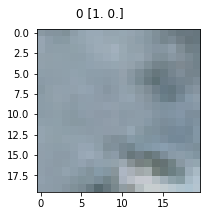

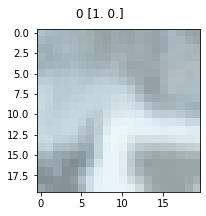

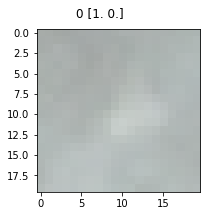

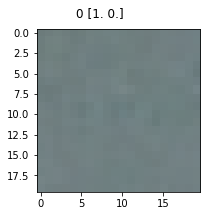

In [7]:
traingen = CustomDataGen(train, batch_size=4, input_shape=(32, 32, 3))

for x, y in traingen:
    break

i = 0
    
for xx, yy in zip(x, y):

    _, ax = plt.subplots(1, 1, figsize=(20, 3))
    ax.imshow(xx[:, :])
    plt.suptitle(str(i)+' '+str(yy))
    plt.show()


In [8]:
xx.shape

(20, 20, 3)

# Train model

In [315]:
def create_model(input_shape=(20, 20, 3)):

    cnn4 = Sequential()
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn4.add(BatchNormalization())
    
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.5))
    
    cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))
    
    cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.5))
    
    cnn4.add(Flatten())
    
    cnn4.add(Dense(512, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))
    
    cnn4.add(Dense(128, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))
    
    cnn4.add(Dense(2, activation='softmax'))
    
    return cnn4

In [316]:
K.clear_session()

model = create_model((20, 20, 3))

# model = load_model('models/check2/model_4conv_b_s_testonbest.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

In [317]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          1

In [318]:
train_df, val_df = train_test_split(train, test_size=0.15)

traingen = CustomDataGen(train_df, batch_size=128)
valgen = CustomDataGen(val_df, batch_size=128, augment=False)

In [319]:
checkpoint_path = 'models/check6/model1.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=16, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=7, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [320]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
206/206 [==============================] - 10s 44ms/step - loss: 0.5347 - accuracy: 0.7901 - auc: 0.8558 - val_loss: 0.7667 - val_accuracy: 0.7496 - val_auc: 0.7572

Epoch 00001: val_loss improved from inf to 0.76673, saving model to models/check6/model1.h5
Epoch 2/100
206/206 [==============================] - 7s 36ms/step - loss: 0.3163 - accuracy: 0.8748 - auc: 0.9395 - val_loss: 0.8780 - val_accuracy: 0.7496 - val_auc: 0.7701

Epoch 00002: val_loss did not improve from 0.76673
Epoch 3/100
206/206 [==============================] - 7s 32ms/step - loss: 0.2567 - accuracy: 0.8958 - auc: 0.9579 - val_loss: 0.5439 - val_accuracy: 0.8014 - val_auc: 0.8743

Epoch 00003: val_loss improved from 0.76673 to 0.54394, saving model to models/check6/model1.h5
Epoch 4/100
206/206 [==============================] - 7s 32ms/step - loss: 0.2286 - accuracy: 0.9072 - auc: 0.9649 - val_loss: 0.2073 - val_accuracy: 0.9065 - val_auc: 0.9688

Epoch 00004: val_loss improved from 0.54394 to 0.207

# Test

In [269]:
model = load_model('models/check6/model1.h5')

preds = []

for f, p in tqdm(zip(test.filename.iloc[:1000], test.path.iloc[:1000])):
    
    temp = []
    
    X = cv2.imread(p).copy()
    
    for q in range(8):
        
        Xaug = augment_image(X)
        
        X2 = Xaug / 255.
        
        pred = model.predict(X2[np.newaxis, ...])[0, 1]
        
        temp.append(pred)
        
    preds.append(np.array(temp))

1000it [01:34, 10.59it/s]


In [275]:
model = load_model('models/check6/model1.h5')

preds2 = []

for f, p in tqdm(zip(test[test.filename.isin(imgs_ex)].filename, test[test.filename.isin(imgs_ex)].path)):
    
    temp = []
    
    X = cv2.imread(p).copy()
    
    X2 = X / 255.
        
    pred = model.predict(X2[np.newaxis, ...])[0, 1]
        
    temp.append(pred)
    
    for i in range(7):
        
        Xaug = augment_image(X)
        
        X2 = Xaug / 255.
        
        pred = model.predict(X2[np.newaxis, ...])[0, 1]
        
        temp.append(pred)
            
    preds2.append(np.mean(np.array(temp)))

686it [01:42,  6.69it/s]


In [270]:
preds = np.array(preds)
preds.shape

(1000, 8)

In [276]:
preds2 = np.array(preds2)
preds2.shape

(686,)

In [333]:
sub = sample_sub.copy()

sub.loc[sub.index < 1000, 'sign'] = [np.mean(pred) for pred in preds]

sub.loc[(sub.index < 1000)&(sub.sign < 0.15), 'sign'] = 0
sub.loc[(sub.index < 1000)&(sub.sign > 0.99), 'sign'] = 1

sub.loc[sub.filename.isin(imgs_ex), 'sign'] = preds2

sub.loc[(sub.index >= 1000)&(sub.sign > 0.1), 'sign'] = 1
sub.loc[(sub.index >= 1000)&(sub.sign < 0.1), 'sign'] = 0

In [338]:
sub.to_csv('sub_last_5.csv', index=False)